In [1]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
iris = datasets.load_iris()
features = iris.data
target = iris.target

sepal_length = np.array(features[:,0])
petal_width = np.array(features[:,3])

species_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
species_names = [species_map[i] for i in target]

Text(0, 0.5, 'Petal Width')

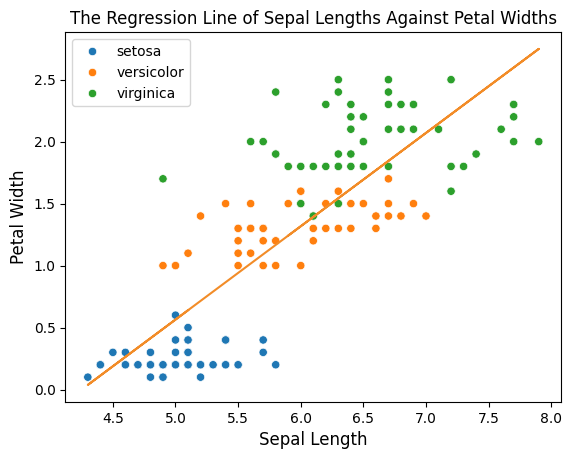

In [3]:
reg = LinearRegression().fit(X = sepal_length.reshape(-1,1), y = petal_width.reshape(-1,1))

sns.scatterplot(x = sepal_length, y = petal_width, hue = species_names)

plt.plot(
    sepal_length, 
    reg.intercept_[0] + reg.coef_[0][0] * features[:, 0], 
    color = '#f28c28'
)

plt.title("The Regression Line of Sepal Lengths Against Petal Widths")
plt.xlabel("Sepal Length", fontsize=12)
plt.ylabel("Petal Width", fontsize=12)

In [4]:
print(reg.intercept_, reg.coef_)

[-3.200215] [[0.75291757]]


From the result above, it tells us two things:
* The intercept starts at $-3.200215$
* The first coefficient is $0.75291757$

So in this case, our regression formula is $y = -3.200215 + 0.75291757 \cdot x_i$.

In [5]:
lr_predictions = reg.predict(sepal_length.reshape(-1,1))
lr_mse = mean_squared_error(lr_predictions, petal_width)
print(f"Linear Regression's MSE is {lr_mse}")

Linear Regression's MSE is 0.19101500769427357


With $y = -3.200215 + 0.75291757 \cdot x_i$, the Mean Squared error is $0.1910150076942736$.

# 1. Gradient Descent

In [6]:
def predict(intercept: int, coefficient: int, x: np.array) -> np.array:
    return intercept + coefficient * x

def gd(x, y, df, epochs = 10000, alpha = 0.01):
    intercept, coefficient = 2.0, -7.5
    length = len(x)
    predictions = predict(intercept, coefficient, x)
    error = predictions - y
    mse = np.sum(error ** 2) / (2 * length)
    df.loc[0] = [intercept, coefficient, mse]

    for epoch in range(1, epochs):
        predictions = predict(intercept, coefficient, x)
        error = predictions - y
        b0_error = np.sum(error) / length
        b1_error = np.sum(error * x) / length
        intercept = intercept - alpha * b0_error
        coefficient = coefficient - alpha * b1_error 
        mse = np.sum(error ** 2) / (2 * length)
        df.loc[epoch] = [intercept, coefficient, mse]
        
    return df

Let's train, or update the weight of our parameters, for 10,000 times.

In [7]:
epochs = 10000
gd_loss = pd.DataFrame(columns=['intercept', 'coefficient', 'mse'])
gd_loss = gd(sepal_length, petal_width, gd_loss, epochs = epochs)

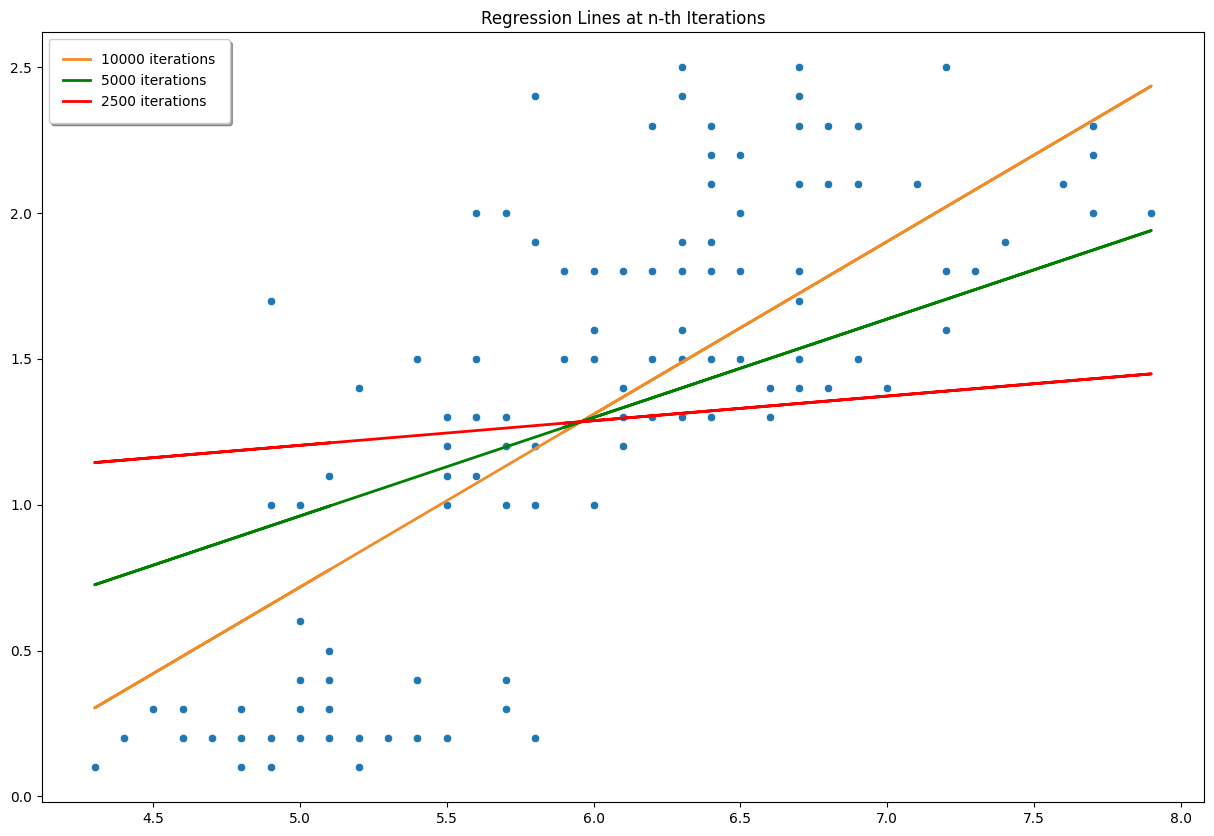

In [8]:
plt.figure(figsize=(15, 10))

sns.scatterplot(
    x = sepal_length, 
    y = petal_width, 
    data = iris
)

iterations = [10000, 5000, 2500]
colors = ['#f28c28', 'g', 'r']

for iteration, color in zip(iterations, colors):
    plt.plot(
        sepal_length, 
        gd_loss.loc[iteration - 1, 'intercept'] + gd_loss.loc[iteration - 1, 'coefficient'] * sepal_length,
        color = color,
        linewidth = 2,
        label = f'{iteration} iterations'
    )
plt.title("Regression Lines at n-th Iterations")
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

(4.2, 8.0)

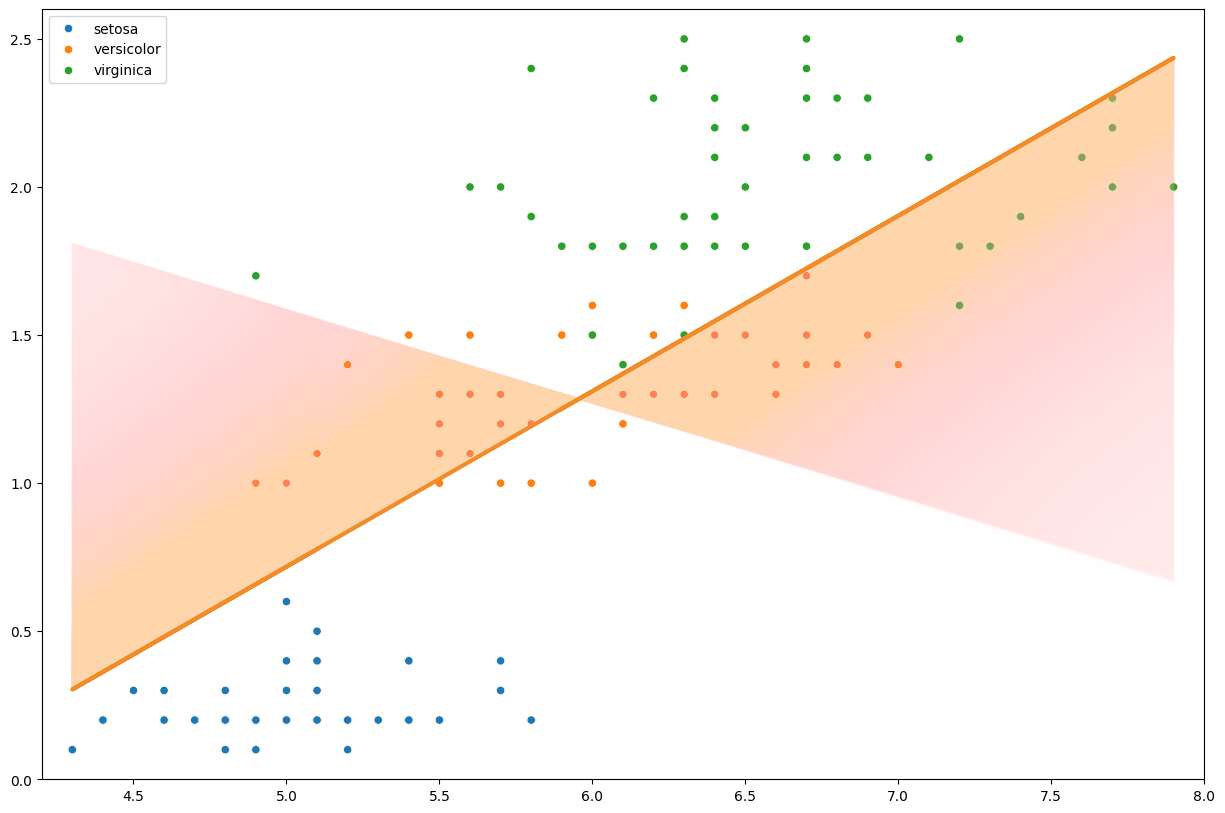

In [9]:
plt.figure(figsize=(15, 10))

sns.scatterplot(
    x = sepal_length, 
    y = petal_width, 
    hue = species_names
)

for i in range(0, epochs-1):
    plt.plot(
        sepal_length, 
        gd_loss['intercept'].loc[i] + gd_loss['coefficient'].loc[i] * sepal_length,
        color = '#ffd5ab',
        linestyle = '-',
        lw = 1,
        alpha = 0.01
    )

plt.plot(
    sepal_length, 
    gd_loss['intercept'].loc[epochs-1] + gd_loss['coefficient'].loc[epochs-1] * sepal_length,
    color = '#f28c28',
    lw = 3,
    linestyle = '-'
)

plt.ylim(0, max(petal_width) + 0.1)
plt.xlim(min(sepal_length) - 0.1, max(sepal_length) + 0.1)

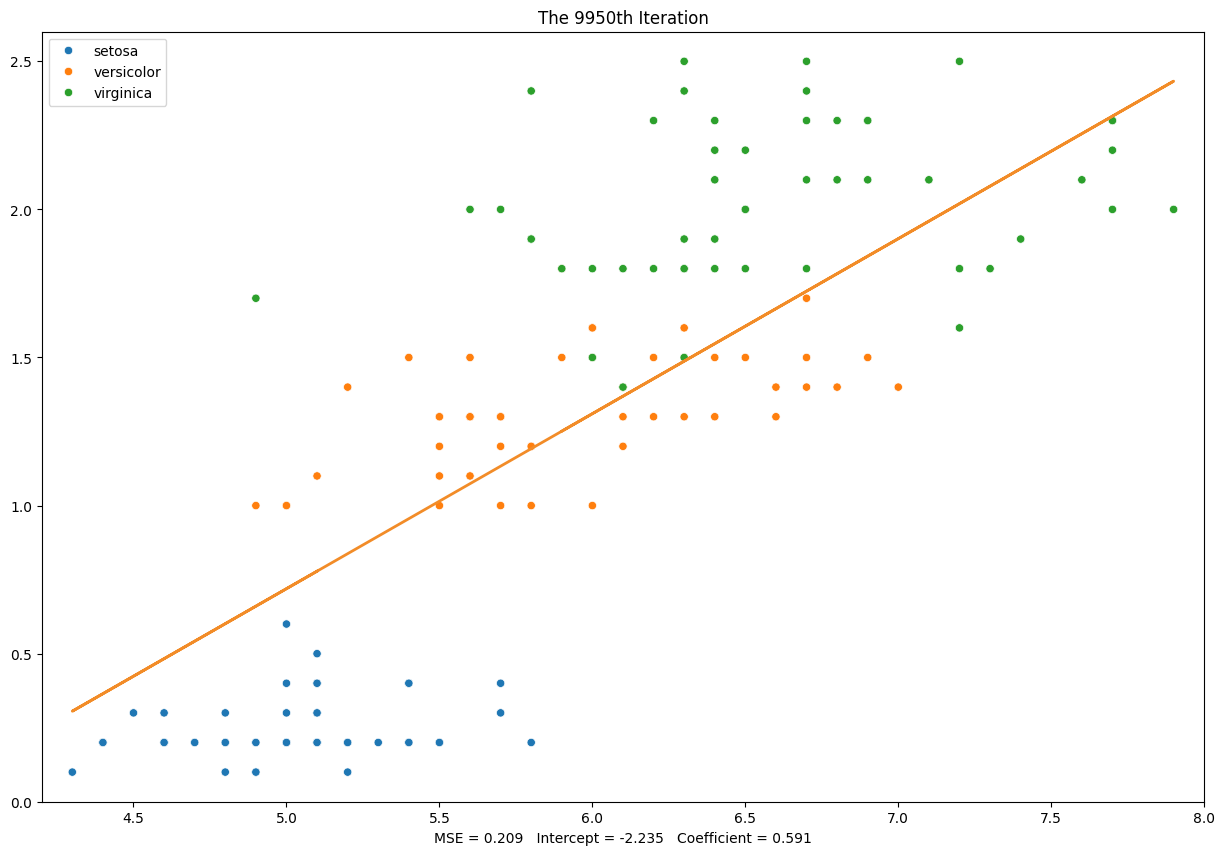

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.xlim(min(sepal_length) - 0.1, max(sepal_length) + 0.1)
plt.ylim(0, max(petal_width) + 0.1)

sns.scatterplot(
    x = sepal_length, 
    y = petal_width, 
    hue = species_names
)

line, = ax.plot(
    sepal_length, 
    gd_loss['intercept'][0] + gd_loss['coefficient'][0] * sepal_length,
    color="#f28c28", 
    linestyle='-',
    linewidth = 2, 
    label = 'regression line'
)

def update(frame_num):
    regline = gd_loss['intercept'].loc[frame_num] + gd_loss['coefficient'].loc[frame_num] * sepal_length
    line.set_ydata(regline)
    plt.title(f"The {frame_num}th Iteration")
    plt.xlabel(f"MSE = {mean_squared_error(regline, petal_width):.3f}   Intercept = {gd_loss['intercept'].loc[frame_num]:.3f}   Coefficient = {gd_loss['coefficient'].loc[frame_num]:.3f}")
    return line, ax

anim = FuncAnimation(fig, update, repeat = True, frames=np.arange(0, epochs, 50), interval=10)
anim.save(
    './gif/bgd.gif', 
    writer = PillowWriter(fps=60), 
    dpi = 150
)
plt.show()

In [11]:
intercepts = np.linspace(-5, 5, 50)
coefficients = np.linspace(-10, 10, 50)
x, y = np.meshgrid(intercepts, coefficients)
z = np.zeros(x.shape)

# calculate the mean squared error for each point on the surface
z = np.array([[mean_squared_error(
    predict(x_i, y_i, sepal_length),
    petal_width
) for x_i in intercepts] for y_i in coefficients])

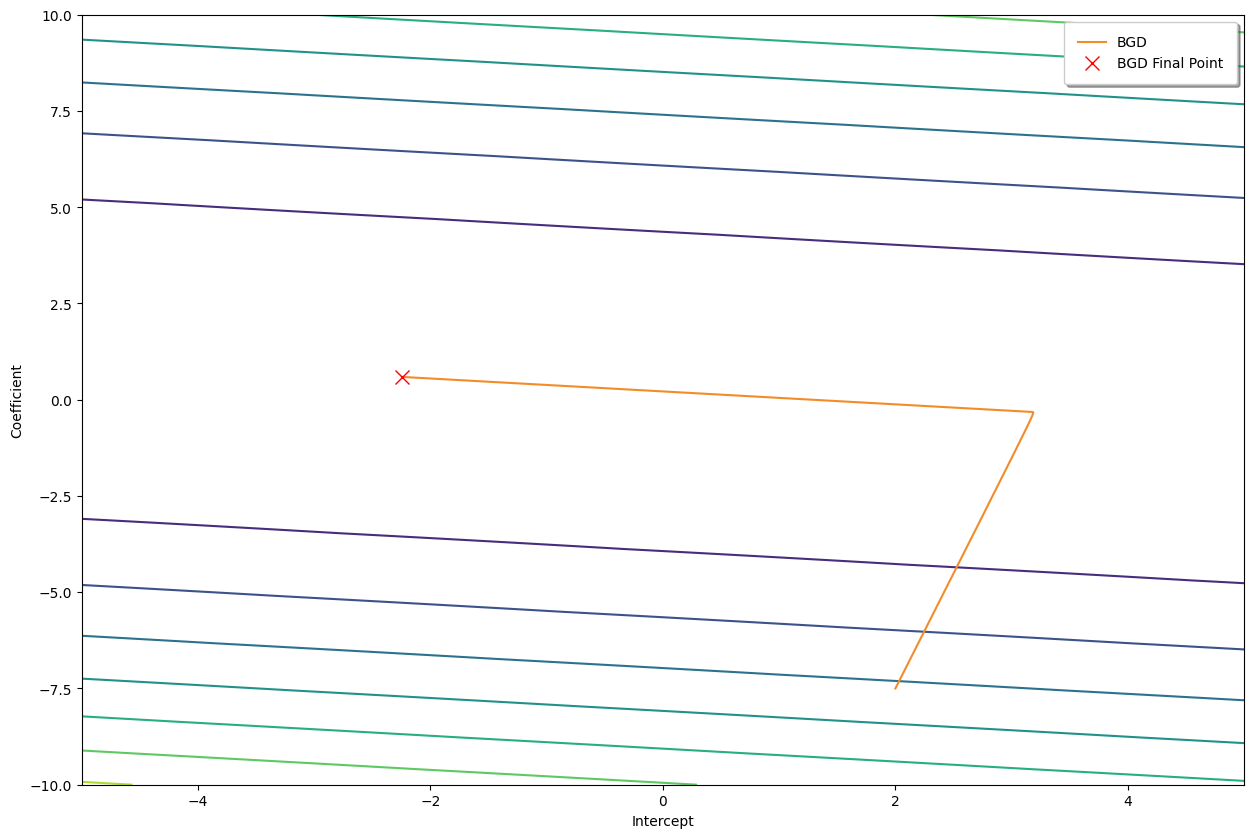

In [12]:
plt.figure(figsize=(15, 10))
plt.contour(x, y, z)
plt.xlabel("Intercept")
plt.ylabel("Coefficient")

plt.plot(
    gd_loss['intercept'][0:len(gd_loss)-2], 
    gd_loss['coefficient'][0:len(gd_loss)-2], 
    color='#f28c28',
    label='BGD'
)

plt.plot(
    gd_loss['intercept'][len(gd_loss)-1], 
    gd_loss['coefficient'][len(gd_loss)-1], 
    'x',
    markersize=10, 
    color='red',
    label="BGD Final Point"
)

plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)